# SLNI 706 project- Sequence analysis course

In [1]:
#Please make sure all import work

#General imports
import os
import re
import json
import torch
from torch.utils import data
import pandas as pd
import datetime
from transformers import BertConfig\

from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import pprint

#Project models imports
import params
import utils
from bert_model import BertTransformer
from training import train_snli
import transformer_model
import basic_rnn
import rnn_combined_model
import snli_dataset
import main_slni
from evaluation import run_test_and_plot_cm
import warnings
warnings.filterwarnings("ignore")

Please check these necessary files are in place

In [2]:

#Data files- Please make sure you have them
TRAIN_DATA_FILE= './data/snli_1.0/snli_1.0_train.jsonl'
VAL_DATA_FILE='./data/snli_1.0/snli_1.0_dev.jsonl'
TEST_DATA_FILE='./data/snli_1.0/snli_1.0_test.jsonl'

#Needed directories -Please make sure you have them.
MODELS_DIR='./saved_models/'
RUNS_DIR='./experiments/'
RESULTS_DIR='./results'

#Please make sure you have this files under MODELS_DIR .
#This is a file I have prepared containing the vocabulary , otherwise the dataset will take long to process.
VOCAB_FILE='vocab_counter.pkl'
TRAIN_TOKENIZED_FILE='train_tokenized_datapoints.pickle'
VAL_TOKENIZED_FILE='val_tokenized_datapoints.pickle'
TEST_TOKENIZED_FILE='test_tokenized_datapoints.pickle'

#Best models-saved checkpoints
BEST_MODEL_BASIC_RNN='./saved_models/best_models/BasicRNN_best_lr:0.001_hidden_size:512  epoch:15 train_iter:257520 val_iter:462004042021 00.pth'

BEST_MODEL_TRANSFORMER='./saved_models/best_models/best_basic_rnn.th'
BEST_MODEL_RNN_COMBINE='./saved_models/best_models/best_basic_rnn.th'
BEST_MODEL_BERT='./saved_models/best_models/best_basic_rnn.th'

In [3]:
#Set device

device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda')

print(device)

cuda


In [4]:
#Set seed to reproduce results
#Repsroducible results
SEED=42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



### We first prepare the datasets for training and validation


In [5]:

train_dataset = snli_dataset.SNLIDataset(data_path=TRAIN_DATA_FILE, saved_dir=MODELS_DIR, device=device,  vocab_file=VOCAB_FILE,tokenized_datapoints_file=TRAIN_TOKENIZED_FILE)
print(f"Train dataset size: {len(train_dataset)} ")

train_vocab=train_dataset.vocab
val_dataset = snli_dataset.SNLIDataset(data_path=VAL_DATA_FILE, saved_dir=MODELS_DIR, device=device, vocab_external=train_vocab,tokenized_datapoints_file=VAL_TOKENIZED_FILE)
print(f"Validation dataset size: {len(val_dataset)} ")

#Count number of datapoint in each label
count_neural=0
count_entailment=0
count_contradiction=0
for datapoint in train_dataset.datapoints:
    if datapoint[2]=="neutral":
        count_neural+=1
    elif datapoint[2]=="contradiction":
        count_contradiction+=1
    elif datapoint[2]=="entailment":
        count_entailment+=1

print(f"Count neutral: {count_neural}")
print(f"Count contradiction: {count_contradiction}")
print(f"Count entailment: {count_entailment}")

Train dataset size: 549367 
Validation dataset size: 9842 
Count neutral: 182764
Count contradiction: 183187
Count entailment: 183416


We can see that the dataset has a good balance

In [6]:
print("Data examples")
print(f"First sentence:{train_dataset.datapoints[0][0]}")
print(f"Second sentence:{train_dataset.datapoints[0][1]}")
print(f"Label:{train_dataset.datapoints[0][2]}\n")

print(f"First sentence:{train_dataset.datapoints[1][0]}")
print(f"Second sentence:{train_dataset.datapoints[1][1]}")
print(f"Label:{train_dataset.datapoints[1][2]}")


Data examples
First sentence:A person on a horse jumps over a broken down airplane.
Second sentence:A person is training his horse for a competition.
Label:neutral

First sentence:A person on a horse jumps over a broken down airplane.
Second sentence:A person is at a diner, ordering an omelette.
Label:contradiction


In [7]:
#utils.save_to_pickle(train_dataset.tokenized_datapoints, './saved_models/train_tokenized_datapoints.pickle')
#utils.save_to_pickle(val_dataset.tokenized_datapoints, './saved_models/val_tokenized_datapoints.pickle')

## Hyperparams tuning

### Basic RNN model

#### Find best hyperparms Basic RNN model


In [8]:
#This RNN configuration is constant
pprint.pprint(params.RNN_CONFIG_CONSTANT_CONFIG)

#We will tune the following hyperparams possibilities
RNN_CONFIG_LIST=[{'config_train':{'run_name': 'lr:0.003_hidden_size:512','num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':0.003}},'config_network':{'hidden_size': 512}},
                 {'config_train':{'run_name': 'lr:0.001_hidden_size:512','num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'hidden_size': 512}},
                 {'config_train':{'run_name': 'lr:0.003_hidden_size:300','num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':0.003}},'config_network':{'hidden_size': 300}},
                 {'config_train':{'run_name': 'lr:0.001_hidden_size:300','num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'hidden_size': 300}}]

{'dropout_rate': 0.1,
 'embeddings_dim': 300,
 'hidden_pre1_classifier_linear_dim': 64,
 'hidden_pre2_classifier_linear_dim': 256,
 'num_classes': 3,
 'pad_token': '<pad>'}


In [9]:
BasicRNN_results_pd=main_slni.train_BasicRNN(train_dataset, val_dataset, RNN_CONFIG_LIST, device, params.RNN_CONFIG_CONSTANT_CONFIG)


Start Training BasicRNN lr:0.003_hidden_size:512 
Step 1000/137344 Train running loss: 0.60
Step 2000/137344 Train running loss: 0.77
Step 3000/137344 Train running loss: 0.84
Step 4000/137344 Train running loss: 0.83
Step 5000/137344 Train running loss: 1.06
Step 6000/137344 Train running loss: 0.82
Step 7000/137344 Train running loss: 0.91
Step 8000/137344 Train running loss: 0.71
Step 9000/137344 Train running loss: 0.79
Step 10000/137344 Train running loss: 0.94
Step 11000/137344 Train running loss: 0.69
Step 12000/137344 Train running loss: 0.96
Step 13000/137344 Train running loss: 0.78
Step 14000/137344 Train running loss: 0.68
Step 15000/137344 Train running loss: 1.06
Step 16000/137344 Train running loss: 1.01
Step 17000/137344 Train running loss: 0.81
*********************************************************************************
BasicRNN Epoch1/8 Train loss: 0.81, Val loss: 0.84  Val accuracy: 65.02  Run params:lr:0.003_hidden_size:512
************************************

Step 1000/137344 Train running loss: 0.78
Step 2000/137344 Train running loss: 1.00
Step 3000/137344 Train running loss: 0.85
Step 4000/137344 Train running loss: 0.83
Step 5000/137344 Train running loss: 0.94
Step 6000/137344 Train running loss: 0.84
Step 7000/137344 Train running loss: 0.56
Step 8000/137344 Train running loss: 0.78
Step 9000/137344 Train running loss: 0.65
Step 10000/137344 Train running loss: 0.59
Step 11000/137344 Train running loss: 0.79
Step 12000/137344 Train running loss: 0.71
Step 13000/137344 Train running loss: 0.60
Step 14000/137344 Train running loss: 0.90
Step 15000/137344 Train running loss: 0.54
Step 16000/137344 Train running loss: 1.13
Step 17000/137344 Train running loss: 0.69
*********************************************************************************
BasicRNN Epoch1/8 Train loss: 0.75, Val loss: 0.84  Val accuracy: 67.31  Run params:lr:0.001_hidden_size:512
*********************************************************************************
Step 

Step 36000/137344 Train running loss: 0.42
Step 37000/137344 Train running loss: 0.79
Step 38000/137344 Train running loss: 0.58
Step 39000/137344 Train running loss: 0.57
Step 40000/137344 Train running loss: 0.62
Step 41000/137344 Train running loss: 0.67
Step 42000/137344 Train running loss: 0.55
Step 43000/137344 Train running loss: 0.68
Step 44000/137344 Train running loss: 0.56
Step 45000/137344 Train running loss: 0.61
Step 46000/137344 Train running loss: 0.56
Step 47000/137344 Train running loss: 0.57
Step 48000/137344 Train running loss: 0.84
Step 49000/137344 Train running loss: 0.70
Step 50000/137344 Train running loss: 0.56
Step 51000/137344 Train running loss: 0.89
*********************************************************************************
BasicRNN Epoch3/8 Train loss: 0.68, Val loss: 0.79  Val accuracy: 68.35  Run params:lr:0.003_hidden_size:300
*********************************************************************************
Step 52000/137344 Train running loss: 0

Step 37000/137344 Train running loss: 0.73
Step 38000/137344 Train running loss: 0.44
Step 39000/137344 Train running loss: 0.69
Step 40000/137344 Train running loss: 0.52
Step 41000/137344 Train running loss: 0.80
Step 42000/137344 Train running loss: 1.06
Step 43000/137344 Train running loss: 0.44
Step 44000/137344 Train running loss: 0.41
Step 45000/137344 Train running loss: 0.65
Step 46000/137344 Train running loss: 0.57
Step 47000/137344 Train running loss: 0.49
Step 48000/137344 Train running loss: 0.62
Step 49000/137344 Train running loss: 0.72
Step 50000/137344 Train running loss: 0.72
Step 51000/137344 Train running loss: 0.66
*********************************************************************************
BasicRNN Epoch3/8 Train loss: 0.57, Val loss: 0.81  Val accuracy: 70.60  Run params:lr:0.001_hidden_size:300
*********************************************************************************
Step 52000/137344 Train running loss: 0.56
Step 53000/137344 Train running loss: 0

lr:0.003_hidden_size:512
lr:0.001_hidden_size:512
lr:0.003_hidden_size:300
lr:0.001_hidden_size:300


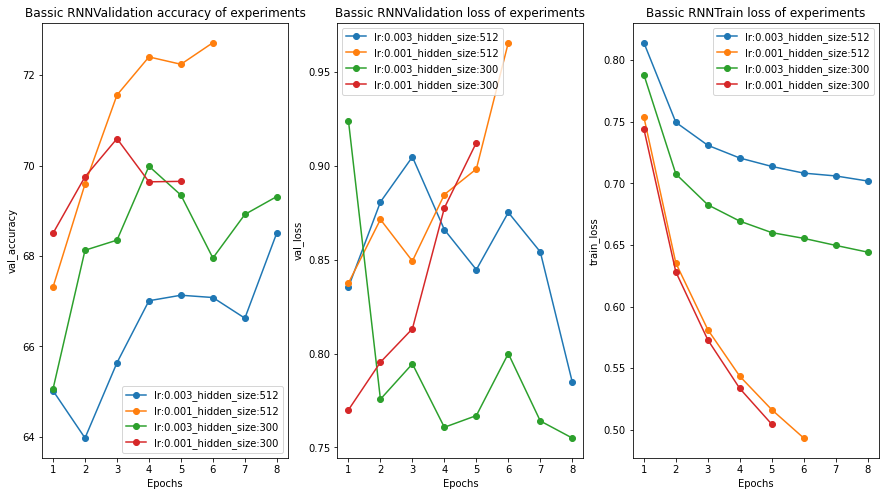

In [11]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Basic_rnn_hyperparams_search' + '.png'), BasicRNN_results_pd, title='Bassic RNN')

We can see that best performence was achieved with hidden value 512 and learning rate 0.001

In [12]:
#Show results
utils.save_to_pickle(BasicRNN_results_pd, './saved_models/basic_rnn_search_results_df.pickle')

In [13]:

#We will load the reuslts from a saved pickle file

PICKLE_BASIC_RNN_SEARH_RESULTS='./saved_models/basic_rnn_search_results_df.pickle'


rnn_basic_search_results=utils.load_from_pickle(PICKLE_BASIC_RNN_SEARH_RESULTS)

lr:0.003_hidden_size:512
lr:0.001_hidden_size:512
lr:0.003_hidden_size:300
lr:0.001_hidden_size:300


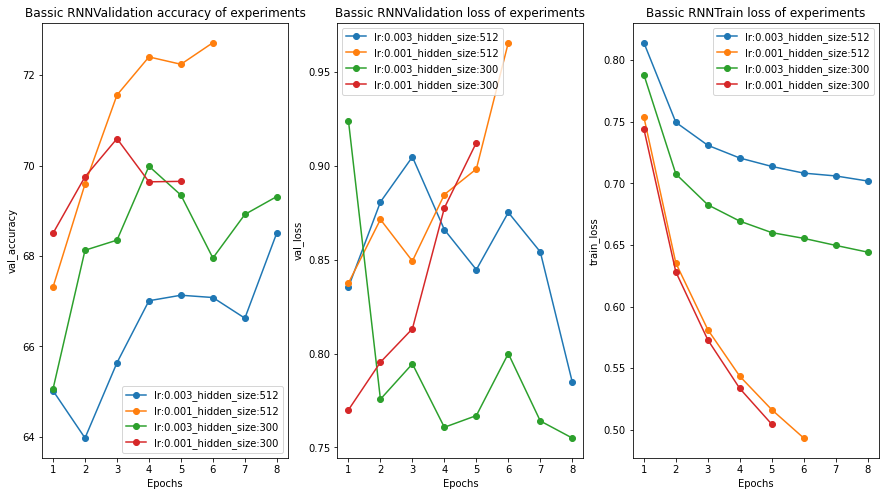

In [14]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Basic_rnn_hyperparams_search' + '.png'), rnn_basic_search_results, title='Bassic RNN')

## RNN Combine model

#### Find best hyperparms RNN Combine model

In [ ]:
#This RNN configuration is constant
pprint.pprint(params.RNN_COMBINE_CONSTANT_CONFIG)

#We will tune the following hyperparams possibilities
RNN_COMBINE_CONFIG_LIST=[{'config_train':{'run_name': 'lr:0.0003_attention_dim:256','num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':0.003}},'config_network':{'attention_dim': 256}},
                         {'config_train':{'run_name': 'lr:0.0001_attention_dim:256','num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'attention_dim': 256}},
                         {'config_train':{'run_name': 'lr:0.0003_attention_dim:512','num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':0.003}},'config_network':{'attention_dim': 512}},
                         {'config_train':{'run_name': 'lr:0.0001_attention_dim:512','num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'attention_dim': 512}}]

In [ ]:
RNNCombine_results_pd=main_slni.train_RNNCombine(train_dataset, val_dataset, RNN_COMBINE_CONFIG_LIST, device, params.RNN_COMBINE_CONSTANT_CONFIG)

In [ ]:
utils.save_to_pickle(RNNCombine_results_pd, './saved_models/rnn_combine_results_df_last.pickle')

In [ ]:

#PICKLE_RNN_COMBINE_SEARH_RESULTS='./saved_models/best_models/rnn_combine_results_df.pickle'

rnn_combine_search_results=utils.load_from_pickle('./saved_models/rnn_combine_results_df_last.pickle')

utils.plot_experiments(os.path.join(MODELS_DIR, 'RNNCombine_hyperparams_search' + '.png'), RNNCombine_results_pd)

We can see that best performennce was achieved with 512 attention dim and 0.0001 learning rate

In [ ]:
utils.save_to_pickle(RNNCombine_results_pd, './saved_models/rnn_combine_results_df.pickle')

In [ ]:
rnn_combine_search_results=utils.load_from_pickle('./saved_models/rnn_combine_results_df.pickle')

In [ ]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'RNNCombine_hyperparams_search' + '.png'), rnn_combine_search_results)

## Transformer model

#### Find best hyperparms Transformer model

In [8]:
#This RNN configuration is constant
pprint.pprint(params.TRANSFORMER_CONSTANT_CONFIG)

TRANSFORMER_CONFIG_LIST=[{'config_train':{'run_name': 'lr:5e-5_num_heads:4', 'num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':5e-5}},'config_network':{'num_heads':4}},
                         {'config_train':{'run_name': 'lr:3e-5_num_heads:4', 'num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':3e-5}},'config_network':{'num_heads':4}},
                         {'config_train':{'run_name': 'lr:5e-5_num_heads:6', 'num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':5e-5}},'config_network':{'num_heads':6}},
                         {'config_train':{'run_name': 'lr:3e-5_num_heads:6', 'num_epochs':8, 'checkpoint': None, 'config_optim':{'lr':3e-5}},'config_network':{'num_heads':6}}]


{'dropout_rate': 0.1,
 'embeddings_dim': 300,
 'hidden_pre1_classifier_linear_dim': 64,
 'hidden_pre2_classifier_linear_dim': 256,
 'max_len': 1000,
 'num_classes': 3,
 'num_enc_layers': 6}


In [9]:
Transformer_results_pd=main_slni.train_Transformer(train_dataset, val_dataset, TRANSFORMER_CONFIG_LIST, device,params.TRANSFORMER_CONSTANT_CONFIG)


Start Training Transformer lr:5e-5_num_heads:4 
Step 1000/137344 Train running loss: 0.78
Step 2000/137344 Train running loss: 0.99
Step 3000/137344 Train running loss: 0.87
Step 4000/137344 Train running loss: 0.86
Step 5000/137344 Train running loss: 0.95
Step 6000/137344 Train running loss: 0.96
Step 7000/137344 Train running loss: 0.91
Step 8000/137344 Train running loss: 0.76
Step 9000/137344 Train running loss: 0.93
Step 10000/137344 Train running loss: 0.93
Step 11000/137344 Train running loss: 0.79
Step 12000/137344 Train running loss: 1.05
Step 13000/137344 Train running loss: 0.83
Step 14000/137344 Train running loss: 0.85
Step 15000/137344 Train running loss: 0.98
Step 16000/137344 Train running loss: 0.98
Step 17000/137344 Train running loss: 1.04
*********************************************************************************
Transformer Epoch1/8 Train loss: 0.91, Val loss: 1.13  Val accuracy: 44.81  Run params:lr:5e-5_num_heads:4
****************************************

Step 2000/137344 Train running loss: 1.02
Step 3000/137344 Train running loss: 1.01
Step 4000/137344 Train running loss: 1.07
Step 5000/137344 Train running loss: 1.02
Step 6000/137344 Train running loss: 0.97
Step 7000/137344 Train running loss: 0.91
Step 8000/137344 Train running loss: 0.96
Step 9000/137344 Train running loss: 0.77
Step 10000/137344 Train running loss: 1.00
Step 11000/137344 Train running loss: 0.96
Step 12000/137344 Train running loss: 1.00
Step 13000/137344 Train running loss: 0.80
Step 14000/137344 Train running loss: 1.02
Step 15000/137344 Train running loss: 0.88
Step 16000/137344 Train running loss: 1.17
Step 17000/137344 Train running loss: 0.91
*********************************************************************************
Transformer Epoch1/8 Train loss: 0.94, Val loss: 1.07  Val accuracy: 47.90  Run params:lr:3e-5_num_heads:4
*********************************************************************************
Step 18000/137344 Train running loss: 0.69
Step 1

Step 4000/137344 Train running loss: 0.85
Step 5000/137344 Train running loss: 0.83
Step 6000/137344 Train running loss: 1.00
Step 7000/137344 Train running loss: 0.86
Step 8000/137344 Train running loss: 0.93
Step 9000/137344 Train running loss: 0.88
Step 10000/137344 Train running loss: 0.76
Step 11000/137344 Train running loss: 1.08
Step 12000/137344 Train running loss: 0.74
Step 13000/137344 Train running loss: 0.73
Step 14000/137344 Train running loss: 0.75
Step 15000/137344 Train running loss: 0.84
Step 16000/137344 Train running loss: 0.79
Step 17000/137344 Train running loss: 0.92
*********************************************************************************
Transformer Epoch1/8 Train loss: 0.90, Val loss: 1.02  Val accuracy: 51.88  Run params:lr:5e-5_num_heads:6
*********************************************************************************
Step 18000/137344 Train running loss: 0.71
Step 19000/137344 Train running loss: 0.73
Step 20000/137344 Train running loss: 0.98
Step

Step 6000/137344 Train running loss: 0.85
Step 7000/137344 Train running loss: 0.78
Step 8000/137344 Train running loss: 0.93
Step 9000/137344 Train running loss: 1.01
Step 10000/137344 Train running loss: 1.02
Step 11000/137344 Train running loss: 1.17
Step 12000/137344 Train running loss: 0.88
Step 13000/137344 Train running loss: 0.98
Step 14000/137344 Train running loss: 0.71
Step 15000/137344 Train running loss: 0.95
Step 16000/137344 Train running loss: 0.78
Step 17000/137344 Train running loss: 0.92
*********************************************************************************
Transformer Epoch1/8 Train loss: 0.93, Val loss: 1.03  Val accuracy: 51.00  Run params:lr:3e-5_num_heads:6
*********************************************************************************
Step 18000/137344 Train running loss: 0.94
Step 19000/137344 Train running loss: 1.01
Step 20000/137344 Train running loss: 0.91
Step 21000/137344 Train running loss: 0.94
Step 22000/137344 Train running loss: 0.70
St

lr:5e-5_num_heads:4
lr:3e-5_num_heads:4
lr:5e-5_num_heads:6
lr:3e-5_num_heads:6


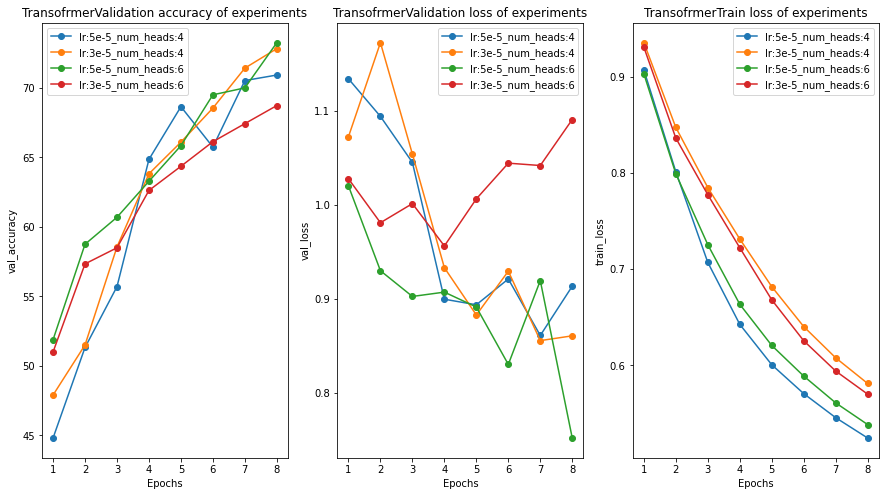

In [11]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Transformer_hyperparams_search' + '.png'), Transformer_results_pd, 'Transofrmer')

In [ ]:

PICKLE_TRANSFORMER_SEARH_RESULTS='./saved_models/best_models/Transformer_results_df.pickle'

transformer_search_results=utils.load_from_pickle(PICKLE_TRANSFORMER_SEARH_RESULTS)

utils.plot_experiments(os.path.join(MODELS_DIR, 'Transformer_hyperparams_search' + '.png'), transformer_search_results, 'Transofrmer')

In [ ]:
utils.plot_train_val_loss(MODELS_DIR, Transformer_results_pd)

In [10]:
utils.save_to_pickle(Transformer_results_pd, './saved_models/transformer_search_results_df.pickle')

## Bert model

#### Find best hyperparms Bert model

In [12]:
pprint.pprint(params.BERT_CONSTANT_CONFIG)


BERT_CONFIG_LIST=[{'run_name': ' lr:5e-5', 'num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':5e-5}},
                  {'run_name': ' lr:3e-5', 'num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':3e-5}}]




{'num_classes': 3, 'output_hidden_states': False}


In [13]:
BERT_results_pd=main_slni.train_Bert(train_dataset, val_dataset, BERT_CONFIG_LIST, device,params.BERT_CONSTANT_CONFIG)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Start Training Bert  lr:5e-5 
Step 1000/68672 Train running loss: 0.49
Step 2000/68672 Train running loss: 0.54
Step 3000/68672 Train running loss: 0.37
Step 4000/68672 Train running loss: 0.38
Step 5000/68672 Train running loss: 0.27
Step 6000/68672 Train running loss: 0.50
Step 7000/68672 Train running loss: 0.19
Step 8000/68672 Train running loss: 0.30
Step 9000/68672 Train running loss: 0.55
Step 10000/68672 Train running loss: 0.28
Step 11000/68672 Train running loss: 0.34
Step 12000/68672 Train running loss: 0.44
Step 13000/68672 Train running loss: 0.35
Step 14000/68672 Train running loss: 0.51
Step 15000/68672 Train running loss: 0.32
Step 16000/68672 Train running loss: 0.34
Step 17000/68672 Train running loss: 0.33
*********************************************************************************
Bert Epoch1/4 Train loss: 0.41, Val loss: 0.32  Val accuracy: 88.38  Run params: lr:5e-5
*********************************************************************************
Step 18000/

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Start Training Bert  lr:3e-5 
Step 1000/68672 Train running loss: 0.51
Step 2000/68672 Train running loss: 0.40
Step 3000/68672 Train running loss: 0.50
Step 4000/68672 Train running loss: 0.23
Step 5000/68672 Train running loss: 0.43
Step 6000/68672 Train running loss: 0.43
Step 7000/68672 Train running loss: 0.30
Step 8000/68672 Train running loss: 0.41
Step 9000/68672 Train running loss: 0.40
Step 10000/68672 Train running loss: 0.28
Step 11000/68672 Train running loss: 0.26
Step 12000/68672 Train running loss: 0.42
Step 13000/68672 Train running loss: 0.24
Step 14000/68672 Train running loss: 0.16
Step 15000/68672 Train running loss: 0.53
Step 16000/68672 Train running loss: 0.15
Step 17000/68672 Train running loss: 0.59
*********************************************************************************
Bert Epoch1/4 Train loss: 0.38, Val loss: 0.29  Val accuracy: 89.42  Run params: lr:3e-5
*********************************************************************************
Step 18000/

In [ ]:
BERT_results_pd

 lr:5e-5
 lr:3e-5


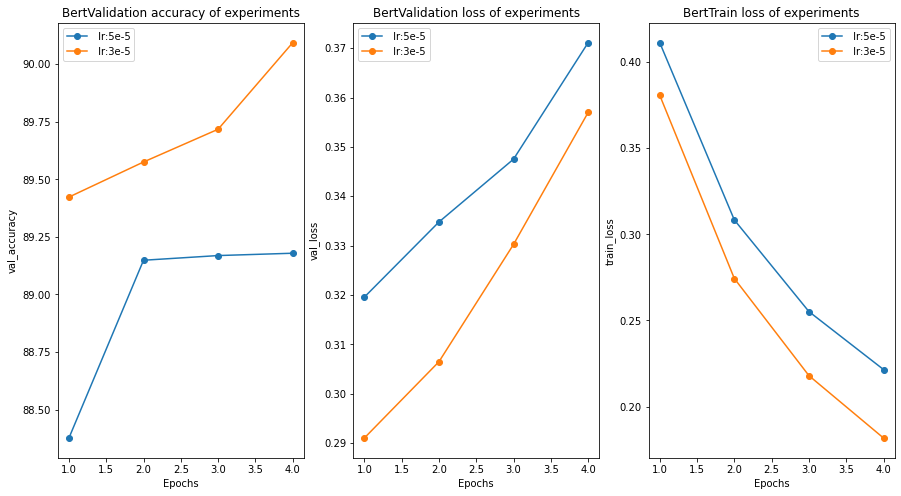

In [15]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'BERT_hyperparams_search' + '.png'), BERT_results_pd, 'Bert')

In [ ]:
utils.plot_train_val_loss(MODELS_DIR, BERT_results_pd)

In [ ]:
bert_search_results=utils.load_from_pickle('./saved_models/bert_results_df.pickle')

In [ ]:
PICKLE_BERT_SEARH_RESULTS='./saved_models/best_models/bert_results_df.pickle'

bert_search_results=utils.load_from_pickle(PICKLE_BERT_SEARH_RESULTS)

utils.plot_experiments(os.path.join(MODELS_DIR, 'BERT_hyperparams_search' + '.png'), bert_search_results, 'Bert')

In [14]:
utils.save_to_pickle(BERT_results_pd, './saved_models/bert_search_results_df.pickle')

In [ ]:
rnn_combine_search_results

# Running all models -each on best hyperparms

Each run with max 20 epochs

### RNN BASIC

In [15]:
#Best config results


RNN_BEST_CONFIG_LIST=[{'config_train':{'run_name': 'best_lr:0.001_hidden_size:512','num_epochs':15, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'hidden_size': 512}}]

In [16]:
BasicRNN_best_pd=main_slni.train_BasicRNN(train_dataset, val_dataset, RNN_BEST_CONFIG_LIST, device, params.RNN_CONFIG_CONSTANT_CONFIG)


Start Training BasicRNN best_lr:0.001_hidden_size:512 
Step 1000/257520 Train running loss: 0.87
Step 2000/257520 Train running loss: 0.73
Step 3000/257520 Train running loss: 0.83
Step 4000/257520 Train running loss: 0.88
Step 5000/257520 Train running loss: 0.72
Step 6000/257520 Train running loss: 0.78
Step 7000/257520 Train running loss: 0.60
Step 8000/257520 Train running loss: 0.76
Step 9000/257520 Train running loss: 0.73
Step 10000/257520 Train running loss: 0.84
Step 11000/257520 Train running loss: 0.80
Step 12000/257520 Train running loss: 0.75
Step 13000/257520 Train running loss: 0.70
Step 14000/257520 Train running loss: 0.71
Step 15000/257520 Train running loss: 0.56
Step 16000/257520 Train running loss: 0.59
Step 17000/257520 Train running loss: 0.72
*********************************************************************************
BasicRNN Epoch1/15 Train loss: 0.75, Val loss: 0.80  Val accuracy: 69.32  Run params:best_lr:0.001_hidden_size:512
*************************

Step 138000/257520 Train running loss: 0.36
Step 139000/257520 Train running loss: 0.41
Step 140000/257520 Train running loss: 0.29
Step 141000/257520 Train running loss: 0.30
Step 142000/257520 Train running loss: 0.69
Step 143000/257520 Train running loss: 0.41
Step 144000/257520 Train running loss: 0.33
Step 145000/257520 Train running loss: 0.48
Step 146000/257520 Train running loss: 0.72
Step 147000/257520 Train running loss: 0.17
Step 148000/257520 Train running loss: 0.29
Step 149000/257520 Train running loss: 0.38
Step 150000/257520 Train running loss: 0.46
Step 151000/257520 Train running loss: 0.62
Step 152000/257520 Train running loss: 0.22
Step 153000/257520 Train running loss: 0.46
Step 154000/257520 Train running loss: 0.27
*********************************************************************************
BasicRNN Epoch9/15 Train loss: 0.44, Val loss: 0.86  Val accuracy: 72.82  Run params:best_lr:0.001_hidden_size:512
*******************************************************

best_lr:0.001_hidden_size:512


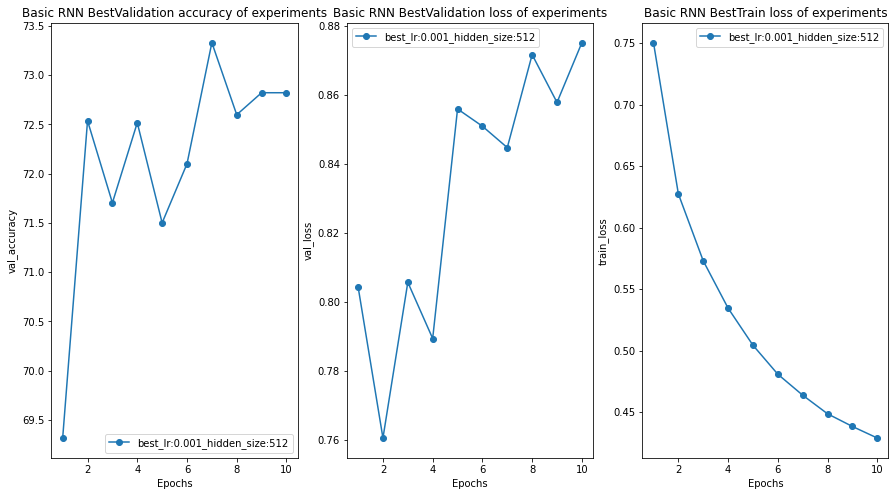

In [18]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Basic_rnn_best_run' + '.png'), BasicRNN_best_pd, title='Basic RNN Best')

best_lr:0.001_hidden_size:512


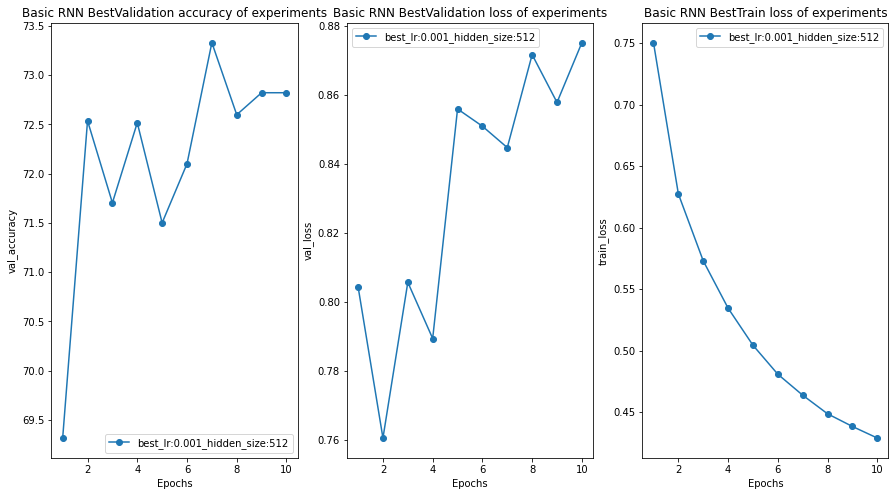

In [31]:
PICKLE_BASIC_RNN_SEARH_RESULTS='./saved_models/BasicRNN_best_results_df.pickle'

BasicRNN_best_pd=utils.load_from_pickle(PICKLE_BASIC_RNN_SEARH_RESULTS)

utils.plot_experiments(os.path.join(MODELS_DIR, 'Basic_rnn_best_run' + '.png'), BasicRNN_best_pd, title='Basic RNN Best')

In [ ]:
BasicRNN_best_pd

We can see that the model achieved 72 Accuracy rate

In [17]:
utils.save_to_pickle(BasicRNN_best_pd, './saved_models/BasicRNN_best_results_df.pickle')

## RNN Combine

In [ ]:
#Best config results

RNN_COMBINE_BEST_CONFIG_LIST=[{'config_train':{'run_name': 'best_lr:0.0001_attention_dim:512','num_epochs':15, 'checkpoint': None, 'config_optim':{'lr':0.001}},'config_network':{'attention_dim': 512}}]

In [ ]:
#running the model

RNNCombine_best_pd=main_slni.train_RNNCombine(train_dataset, val_dataset, RNN_COMBINE_BEST_CONFIG_LIST, device, params.RNN_COMBINE_CONSTANT_CONFIG)

In [ ]:
utils.save_to_pickle(RNNCombine_best_pd, './saved_models/RNNCombine_best_results_df.pickle')

In [ ]:
PICKLE_RNN_COMBINE_SEARH_RESULTS='./saved_models/best_models/RNNCombine_best_results_df.pickle'

BasicRNN_best_pd=utils.load_from_pickle(PICKLE_RNN_COMBINE_SEARH_RESULTS)


utils.plot_experiments(os.path.join(MODELS_DIR, 'Basic_rnn_best_run' + '.png'), BasicRNN_best_pd, title='Basic RNN Best')

## Transformer

In [18]:
#Best config results

TRANSFORMER_BEST_CONFIG_LIST=[{'config_train':{'run_name': 'best_lr:5e-5_num_heads:6', 'num_epochs':14, 'checkpoint': None, 'config_optim':{'lr':5e-5}},'config_network':{'num_heads':6}}]


In [19]:
Transformer_best_pd=main_slni.train_Transformer(train_dataset, val_dataset, TRANSFORMER_BEST_CONFIG_LIST, device,params.TRANSFORMER_CONSTANT_CONFIG)


Start Training Transformer best_lr:5e-5_num_heads:6 
Step 1000/240352 Train running loss: 0.85
Step 2000/240352 Train running loss: 0.91
Step 3000/240352 Train running loss: 0.99
Step 4000/240352 Train running loss: 0.98
Step 5000/240352 Train running loss: 1.05
Step 6000/240352 Train running loss: 0.90
Step 7000/240352 Train running loss: 0.75
Step 8000/240352 Train running loss: 0.78
Step 9000/240352 Train running loss: 0.84
Step 10000/240352 Train running loss: 0.87
Step 11000/240352 Train running loss: 0.74
Step 12000/240352 Train running loss: 0.91
Step 13000/240352 Train running loss: 1.09
Step 14000/240352 Train running loss: 0.99
Step 15000/240352 Train running loss: 0.90
Step 16000/240352 Train running loss: 0.91
Step 17000/240352 Train running loss: 0.95
*********************************************************************************
Transformer Epoch1/14 Train loss: 0.91, Val loss: 1.11  Val accuracy: 48.12  Run params:best_lr:5e-5_num_heads:6
*****************************

In [20]:
utils.save_to_pickle(Transformer_best_pd, './saved_models/Transformer_best_results_df.pickle')

best_lr:5e-5_num_heads:6


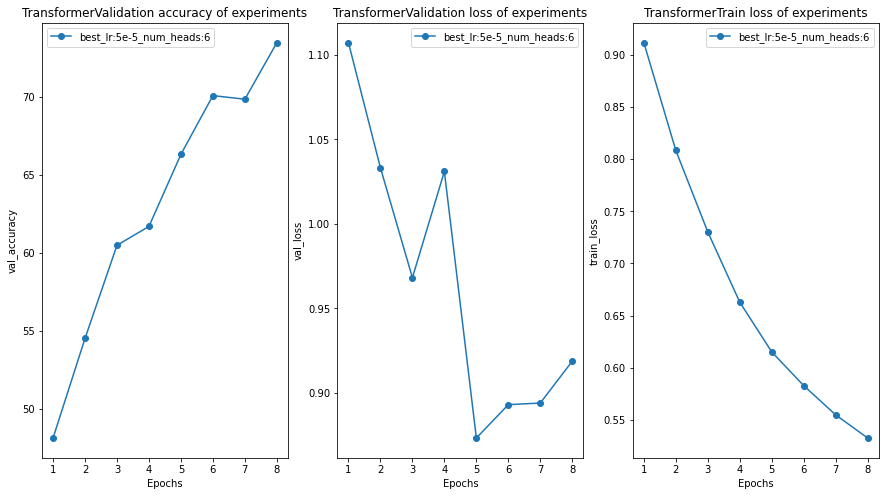

In [22]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Transformer_best_run' + '.png'), Transformer_best_pd, title='Transformer')

In [ ]:
PICKLE_TRANSFORMER_SEARH_RESULTS='./saved_models/best_models/Transformer_best_results_df.pickle'

Transformer_best_pd=utils.load_from_pickle(PICKLE_TRANSFORMER_SEARH_RESULTS)


utils.plot_experiments(os.path.join(MODELS_DIR, 'Transformer_best_run' + '.png'), Transformer_best_pd, title='Transformer_best')

## Bert

In [23]:
BERT_BEST_CONFIG_LIST=[{'run_name': ' best_17lr:3e-5', 'num_epochs':4, 'checkpoint': None, 'config_optim':{'lr':3e-5}}]

In [24]:
BERT_best_pd=main_slni.train_Bert(train_dataset, val_dataset, BERT_BEST_CONFIG_LIST, device,params.BERT_CONSTANT_CONFIG)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Start Training Bert  best_17lr:3e-5 
Step 1000/68672 Train running loss: 0.48
Step 2000/68672 Train running loss: 0.47
Step 3000/68672 Train running loss: 0.56
Step 4000/68672 Train running loss: 0.51
Step 5000/68672 Train running loss: 0.26
Step 6000/68672 Train running loss: 0.29
Step 7000/68672 Train running loss: 0.37
Step 8000/68672 Train running loss: 0.27
Step 9000/68672 Train running loss: 0.54
Step 10000/68672 Train running loss: 0.18
Step 11000/68672 Train running loss: 0.43
Step 12000/68672 Train running loss: 0.43
Step 13000/68672 Train running loss: 0.26
Step 14000/68672 Train running loss: 0.27
Step 15000/68672 Train running loss: 0.27
Step 16000/68672 Train running loss: 0.22
Step 17000/68672 Train running loss: 0.47
*********************************************************************************
Bert Epoch1/4 Train loss: 0.38, Val loss: 0.29  Val accuracy: 89.83  Run params: best_17lr:3e-5
*******************************************************************************

In [ ]:
PICKLE_BERT_SEARH_RESULTS='./saved_models/best_models/bert_best_results_df.pickle'

bert_best_pd=utils.load_from_pickle(PICKLE_BERT_SEARH_RESULTS)


utils.plot_experiments(os.path.join(MODELS_DIR, 'Bert_best_run' + '.png'),bert_best_pd, title='Bert_best')

In [25]:
utils.save_to_pickle(BERT_best_pd, './saved_models/bert_best_results_df.pickle')

 best_17lr:3e-5


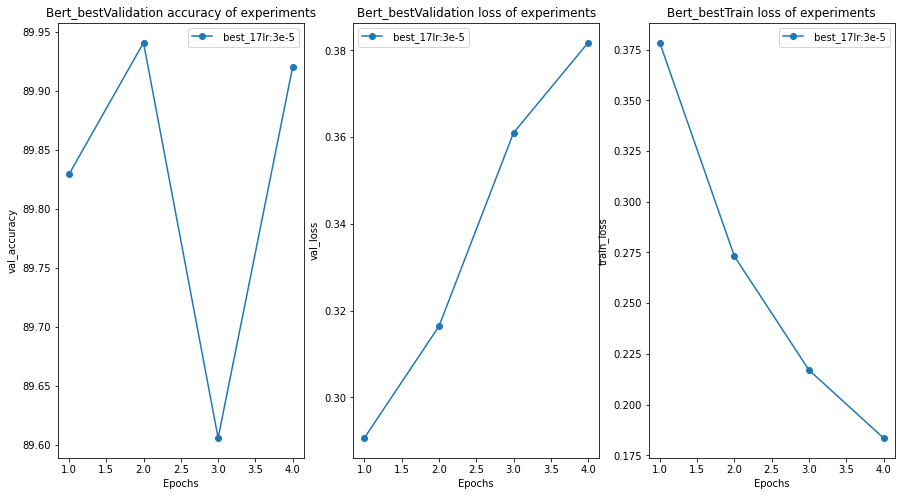

In [27]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'Bert_best_run' + '.png'),BERT_best_pd, title='Bert_best')

In [33]:
BasicRNN_best_pd

,run_name,model,train_loss,val_loss,val_accuracy,checkpoint,epochs,train_iter,val_iter
0,best_lr:0.001_hidden_size:512,BasicRNN,0.750283,0.804312,69.315180,None,1,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
1,best_lr:0.001_hidden_size:512,BasicRNN,0.627381,0.760437,72.536070,None,2,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
2,best_lr:0.001_hidden_size:512,BasicRNN,0.572990,0.805603,71.702906,None,3,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
3,best_lr:0.001_hidden_size:512,BasicRNN,0.534523,0.789303,72.515749,None,4,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
4,best_lr:0.001_hidden_size:512,BasicRNN,0.504384,0.855876,71.499695,None,5,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
5,best_lr:0.001_hidden_size:512,BasicRNN,0.480822,0.850872,72.099167,None,6,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
6,best_lr:0.001_hidden_size:512,BasicRNN,0.463782,0.844672,73.328592,None,7,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
7,best_lr:0.001_hidden_size:512,BasicRNN,0.448651,0.871629,72.597033,None,8,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
8,best_lr:0.001_hidden_size:512,BasicRNN,0.438362,0.857778,72.820565,None,9,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."
9,best_lr:0.001_hidden_size:512,BasicRNN,0.428963,0.875100,72.820565,None,10,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464, ..."


In [34]:
Transformer_best_pd



,run_name,model,train_loss,val_loss,val_accuracy,checkpoint,epochs,train_iter,val_iter
0,best_lr:5e-5_num_heads:6,Transformer,0.911536,1.107183,48.120301,None,1,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
1,best_lr:5e-5_num_heads:6,Transformer,0.808251,1.033151,54.511278,None,2,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
2,best_lr:5e-5_num_heads:6,Transformer,0.730150,0.968095,60.485674,None,3,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
3,best_lr:5e-5_num_heads:6,Transformer,0.662878,1.030958,61.694777,None,4,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
4,best_lr:5e-5_num_heads:6,Transformer,0.615230,0.873200,66.317822,None,5,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
5,best_lr:5e-5_num_heads:6,Transformer,0.582932,0.892951,70.087381,None,6,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
6,best_lr:5e-5_num_heads:6,Transformer,0.554896,0.893918,69.853688,None,7,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"
7,best_lr:5e-5_num_heads:6,Transformer,0.532725,0.918654,73.481000,None,8,"[17168, 34336, 51504, 68672, 85840, 103008, 12...","[308, 616, 924, 1232, 1540, 1848, 2156, 2464]"


In [35]:
BERT_best_pd

,run_name,model,train_loss,val_loss,val_accuracy,checkpoint,epochs,train_iter,val_iter
0,best_17lr:3e-5,Bert,0.378405,0.290617,89.829303,None,1,"[17168, 34336, 51504, 68672]","[308, 616, 924, 1232]"
1,best_17lr:3e-5,Bert,0.273184,0.316384,89.941069,None,2,"[17168, 34336, 51504, 68672]","[308, 616, 924, 1232]"
2,best_17lr:3e-5,Bert,0.217065,0.361005,89.605771,None,3,"[17168, 34336, 51504, 68672]","[308, 616, 924, 1232]"
3,best_17lr:3e-5,Bert,0.183547,0.381792,89.920748,None,4,"[17168, 34336, 51504, 68672]","[308, 616, 924, 1232]"


In [36]:
all_models_df=pd.concat((BasicRNN_best_pd,Transformer_best_pd,BERT_best_pd))



In [41]:
all_models_df['run_name']=all_models_df['model']

BasicRNN
Transformer
Bert


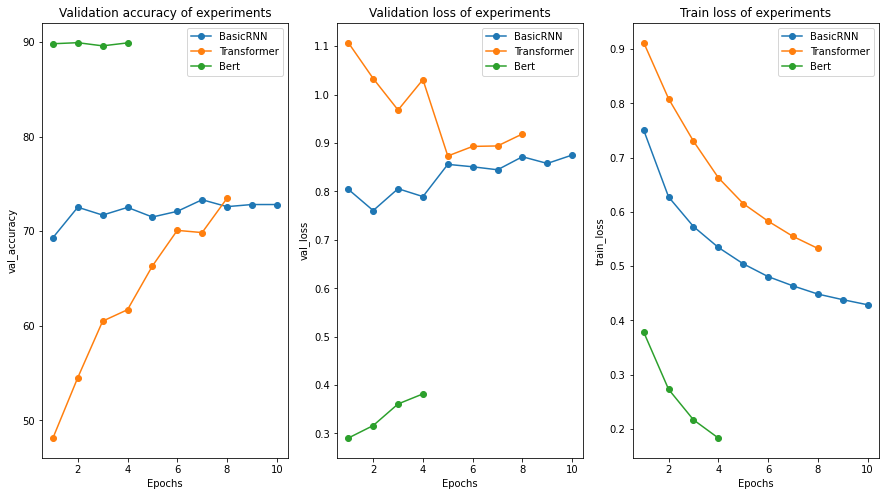

In [42]:
utils.plot_experiments(os.path.join(MODELS_DIR, 'All models_results' + '.png'), all_models_df)

In [8]:
train_vocab=train_dataset.vocab
test_dataset = snli_dataset.SNLIDataset(data_path=TEST_DATA_FILE, saved_dir=MODELS_DIR, device=device, vocab_external=train_vocab)
print(f"Test dataset size: {len(test_dataset)} ")

Test dataset size: 9824 


In [11]:
model=BertTransformer(**params.BERT_CONSTANT_CONFIG).to(device)
CHECKPOINT_BEST_BERT='Bert best_17lr:3e-5  epoch:4 train_iter:68672 val_iter:123204072021 14.pth'

test_dataset.change_tokenizer_and_vocab(tokenizer='bert', eng_mode='one_sentence')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
run_test_and_plot_cm(model, test_dataset, MODELS_DIR, CHECKPOINT_BEST_BERT, 'bert', device)

AttributeError: 'NoneType' object has no attribute 'append'

In [ ]:
#utils.save_to_pickle(test_dataset.tokenized_datapoints, './saved_models/test_tokenized_datapoints.pickle')

In [ ]:
run_test_and_plot_cm



